# Task 1: SQL

In [1]:
"""
select 
user_id, 
ntile(10) over (order by cnt) as decile,
category 
from 
(select 
count(event_id ) over (partition by user_id order by timestamp) as cnt,  
rank() over (partition by user_id order by timestamp desc) as rk 
event_id, user_id, category, timestamp
from 
(select distinct event_id, user_id, category, timestamp
from design_exported 
where datediff('day',current_date,to_timestamp(timestamp))<=7
) as raw
) as a
where rk=1

"""

"\nselect \nuser_id, \nntile(10) over (order by cnt) as decile,\ncategory \nfrom \n(select \ncount(event_id ) over (partition by user_id order by timestamp) as cnt,  \nrank() over (partition by user_id order by timestamp desc) as rk \nevent_id, user_id, category, timestamp\nfrom \n(select distinct event_id, user_id, category, timestamp\nfrom design_exported \nwhere datediff('day',current_date,to_timestamp(timestamp))<=7\n) as raw\n) as a\nwhere rk=1\n\n"

# Task 2: experiment analysis

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import random
plt.style.use('ggplot')


In [2]:
df=pd.read_csv('/Users/didi/Desktop/manual_elevations_experiment_data.csv')
df.head()

,experiment_day,search_id,user_id,experiment_group,user_tier,query,media_types,num_elevations,num_clicks,num_exported_results,num_licenses
0,65,AOGFabmo,51b2325a,B,free,speech bubble,RV,0,1,0,0
1,65,AIT27lH-,97c2ab50,A,paid,line,RV,80,2,1,0
2,65,AMgr6dQc,d626988c,B,free,button,RV,0,1,0,0
3,65,WKgECNwN,8bcaf483,B,free,apple,RV,0,0,0,0
4,65,dzdr0OMT,ca240171,A,paid,banner,RV,80,1,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688377 entries, 0 to 1688376
Data columns (total 11 columns):
experiment_day          1688377 non-null int64
search_id               1688377 non-null object
user_id                 1688377 non-null object
experiment_group        1688377 non-null object
user_tier               1688377 non-null object
query                   1688375 non-null object
media_types             1688377 non-null object
num_elevations          1688377 non-null int64
num_clicks              1688377 non-null int64
num_exported_results    1688377 non-null int64
num_licenses            1688377 non-null int64
dtypes: int64(5), object(6)
memory usage: 141.7+ MB


## Data cleaning 
* remove missing values and duplicates
* num_click should be greater than or equal to num_exported and num_licenses

In [4]:
df.isnull().sum()

experiment_day          0
search_id               0
user_id                 0
experiment_group        0
user_tier               0
query                   2
media_types             0
num_elevations          0
num_clicks              0
num_exported_results    0
num_licenses            0
dtype: int64

In [5]:
df=df.dropna()

In [6]:
df=df[df.experiment_group.isin(['A','B'])]

In [7]:
temp=df.groupby('search_id').user_id.count()
delete_search=temp[temp>1].index
print(str(len(delete_search))+' search_id are showed more than once, they are removed')
df_new=df[~df.search_id.isin(delete_search)]

2 search_id are showed more than once, they are removed


In [8]:
df_new=df_new[(df_new.num_licenses<=df_new.num_clicks)&
              (df_new.num_exported_results<=df_new.num_clicks)&
              (df_new.num_exported_results>=df_new.num_licenses)]

## Check experiment data 
* each user should be in only one group
* number of user in two group should be equal (traffice randomly assigned)

In [9]:
temp=df.groupby('user_id').experiment_group.nunique()
delete_user=temp[temp>1].index
print(str(len(delete_user))+' users are in two groups, they are removed')
df_new=df_new[~df_new.user_id.isin(delete_user)]

21 users are in two groups, they are removed


In [10]:
# check whehter the gap between number of users in two group are normal ?
from scipy.stats import norm

a=len(df_new[df_new.experiment_group=='A'].user_id.unique())
b=len(df_new[df_new.experiment_group=='B'].user_id.unique())

print(a,' users in group a')
print(b,' users in group b')

cdf=norm(0.5,math.sqrt(0.5*0.5/(a+b))).cdf(a/(a+b))

print('cdf is: {:.3f}'.format(cdf))
if cdf>0.975 or cdf<0.025:
    print('Imbalanced, difference in user numbers between two groups is not normal')
else:
    print('Balanced, difference in user numbers between two groups is normal')

280104  users in group a
279688  users in group b
cdf is: 0.711
Balanced, difference in user numbers between two groups is normal


In [11]:
# check whehter the gap between number of search in two group are normal ?
from scipy.stats import norm

a=len(df_new[df_new.experiment_group=='A'].search_id.unique())
b=len(df_new[df_new.experiment_group=='B'].search_id.unique())

print(a,' search sessions in group a')
print(b,' search sessions in group b')

cdf=norm(0.5,math.sqrt(0.5*0.5/(a+b))).cdf(a/(a+b))

print('cdf is: {:.3f}'.format(cdf))
if cdf>0.975 or cdf<0.025:
    print('Imbalanced, difference in search numbers between two groups is not normal')
else:
    print('Balanced, difference in search numbers between two groups is normal')

838438  search sessions in group a
845133  search sessions in group b
cdf is: 0.000
Imbalanced, difference in search numbers between two groups is not normal


Text(0, 0.5, 'daily active use')

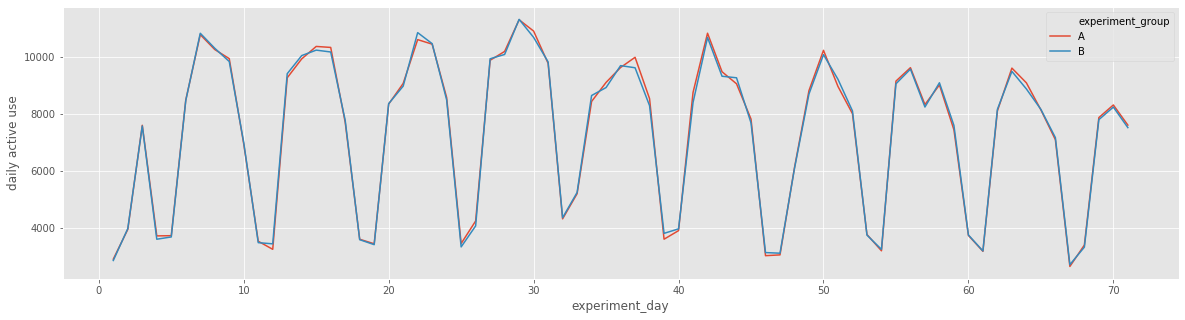

In [13]:
temp=df_new.groupby(['experiment_day','experiment_group']).agg({'user_id':pd.Series.nunique,'search_id':'count'})
temp=temp.reset_index()
temp['avg_search']=temp['search_id']/temp['user_id']

plt.figure(figsize=(20,5))
p=sns.lineplot(data=temp,x='experiment_day',hue='experiment_group',y='user_id')
p.set_ylabel('daily active use')

Text(0, 0.5, 'daily exporter user')

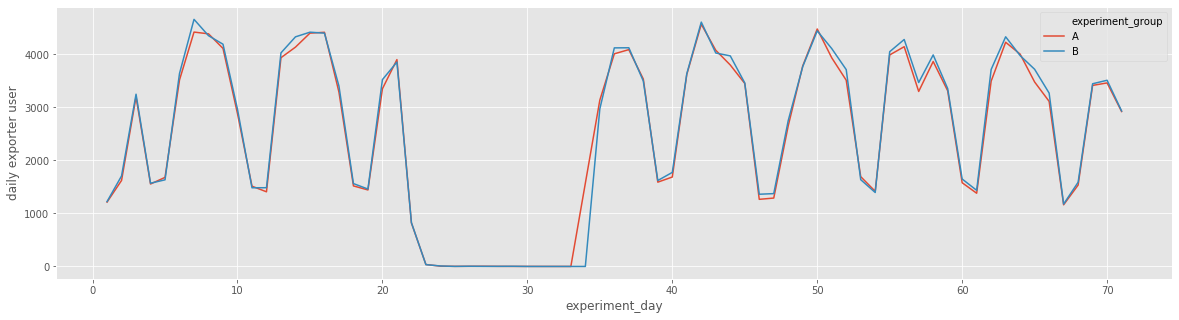

In [16]:
temp=df_new[df_new.is_exported==1].groupby(['experiment_day','experiment_group']).agg({'user_id':pd.Series.nunique,'search_id':'count'})
temp=temp.reset_index()

plt.figure(figsize=(20,5))
p=sns.lineplot(data=temp,x='experiment_day',hue='experiment_group',y='user_id')
p.set_ylabel('daily exporter user')

Text(0, 0.5, 'daily clicked user')

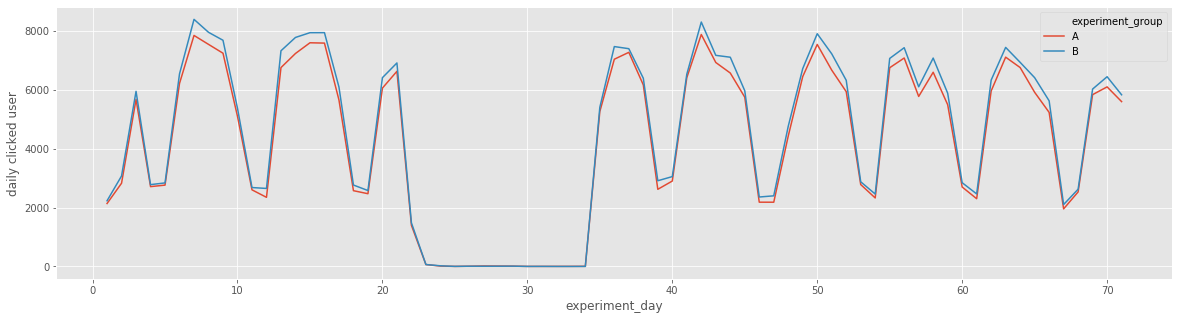

In [18]:
temp=df_new[df_new.is_clicked==1].groupby(['experiment_day','experiment_group']).agg({'user_id':pd.Series.nunique,'search_id':'count'})
temp=temp.reset_index()

plt.figure(figsize=(20,5))
p=sns.lineplot(data=temp,x='experiment_day',hue='experiment_group',y='user_id')
p.set_ylabel('daily clicked user')

In [23]:
pd.set_option('display.max_rows',None)
temp=df_new[df_new.is_clicked==1].groupby(['experiment_day','experiment_group']).agg({'user_id':pd.Series.nunique,'search_id':'count'})
temp

user_id  search_id
experiment_day experiment_group                    
1              A                    2140       3168
               B                    2233       3314
2              A                    2829       4244
               B                    3076       4642
3              A                    5679       8479
               B                    5952       8810
4              A                    2714       3962
               B                    2782       4046
5              A                    2765       4037
               B                    2840       4194
6              A                    6223       9161
               B                    6547       9627
7              A                    7852      11955
               B                    8399      12804
8              A                    7549      11363
               B                    7959      11857
9              A                    7248      10871
               B                    7688      11546
10             A                    5101       7305
               B                    5375       7743
11             A                    2605       3796
               B                    2683       3955
12             A                    2350       3371
               B                    2652       3905
13             A                    6760      10002
               B                    7331      10888
14             A                    7239      10639
               B                    7784      11711
15             A                    7603      11479
               B                    7946      11904
16             A                    7592      11297
               B                    7947      11987
17             A                    5660       8435
               B                    6099       8834
18             A                    2576       3689
               B                    2768       4127
19             A                    2473       3534
               B                    2581       3760
20             A                    6063       8767
               B                    6417       9414
21             A                    6633       9687
               B                    6917      10142
22             A                    1400       1939
               B                    1483       2063
23             A                      65         98
               B                      66         78
24             A                      14         16
               B                      23         42
25             A                       3          3
               B                       3          3
26             A                       9         11
               B                       9         16
27             A                      18         34
               B                       8         12
28             A                      15         31
               B                       9         16
29             A                      12         34
               B                      11         15
30             A                       3          5
               B                       2          2
31             A                       3          3
               B                       3          7
32             B                       1          1
33             A                       4          5
               B                       1          1
34             A                       6         13
               B                       2          2
35             A                    5267       7619
               B                    5410       7902
36             A                    7044      10395
               B                    7474      11259
37             A                    7278      10772
               B                    7402      11110
38             A                    6171       8993
               B                    6397       9488
39             A             

In [25]:
df_new=df_new[(df_new.experiment_day<22)|(df_new.experiment_day>34)]

Text(0, 0.5, 'avg num of searches per user')

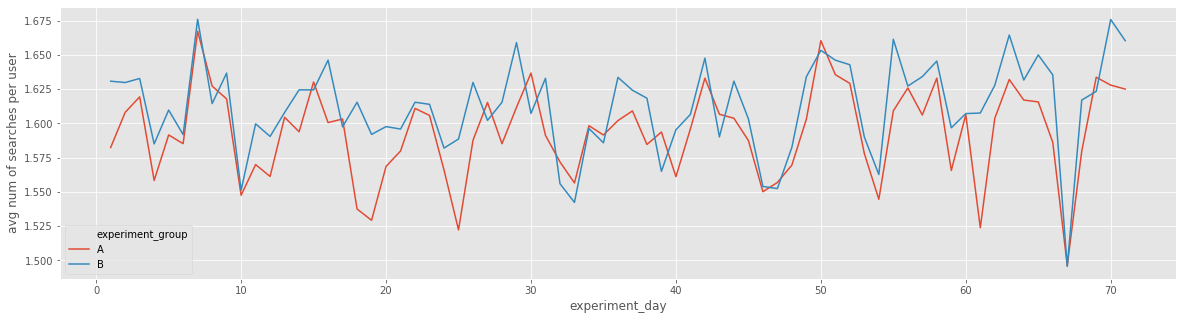

In [14]:
plt.figure(figsize=(20,5))
p=sns.lineplot(data=temp,x='experiment_day',hue='experiment_group',y='avg_search')
p.set_ylabel('avg num of searches per user')

**Numbers of search are significantly different, analysis unit should be user_id instead of search_id**   

The daily plot shows strong seasonality. 

And according to the plots, the gap of search times is not because of number of users, but because of search times difference between two groups.

Difference of search times may cause by unrandomly traffic assignment, users in two groups are not same at the first place. Or it is caused by the experiment interference, the automated elevation mechanism leads to more search times.

Since there is no AA data to prove the homogeneity of two groups of users, in the problem I assume the traffic assignment is okay, the difference is caused by the experiment interference

## Define metrics 
To understand this problem better, I played with Canva. Everytime I click on a picuture, it shows on my design automatically. Then I can download my design, but have to pay if any licensed picutre is used in my design. 
From my own experience, I consider downloading design as a very important checkpoint, meaning the user finish the whole design process. The number of finishing design is measurement of user usage of this product. 

The user may or may not has licensed pictures in design, but payment for licensed picture is related to the company revenue.  

We wish user to create more designs and pay for the licensed pictures. 
So, here I focus on two metrics:   
* **average num of finished design per user had** 
* **average num of licensed picture per user paid for**   

Finished design = (num_exported_results>=1)  
Number of finished design = Number of search * conversion rate 

Finishing and downloading a design is final result, number of search and conversion rate are signs of customer experience during the process.
Number of pictures exported is also worth consideration. It shows how many pictures from canva is used by users in their designs.

In [12]:
# exported more than 1 picture means design finished
df_new['is_exported']=np.where(df_new['num_exported_results']>=1,1,0)

# clicked on more than 1 picture means relevent search result
df_new['is_clicked']=np.where(df_new['num_clicks']>=1,1,0)


# EDA
- data distribution by categorical variables 
- how key metrics vary between different categories 

In [13]:
# day of week is just a calling here, I dont know the exact date 
df_new['day_of_week']=df_new['experiment_day'].apply(lambda x:divmod(x,7)[1])

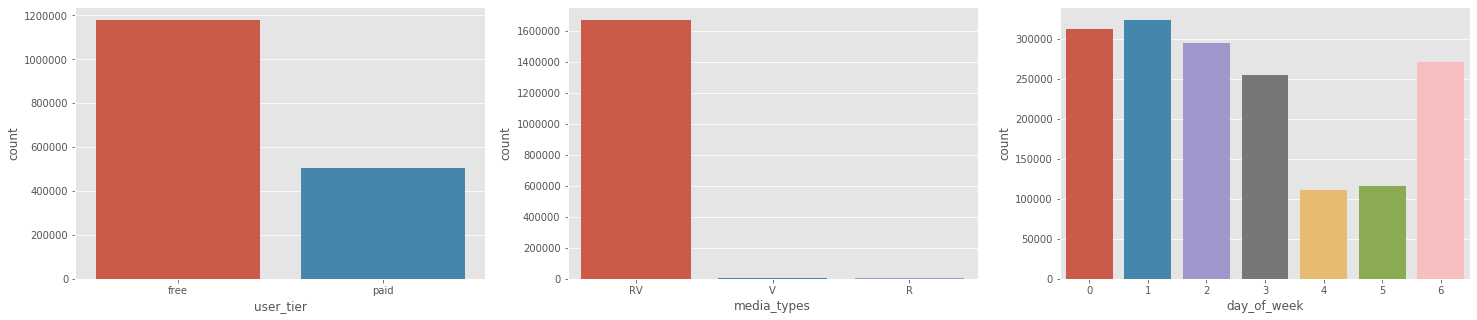

In [17]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(25,5))

sns.countplot(data=df_new,x='user_tier',ax=ax.flatten()[0])
sns.countplot(data=df_new,x='media_types',ax=ax.flatten()[1])
sns.countplot(data=df_new,x='day_of_week',ax=ax.flatten()[2])

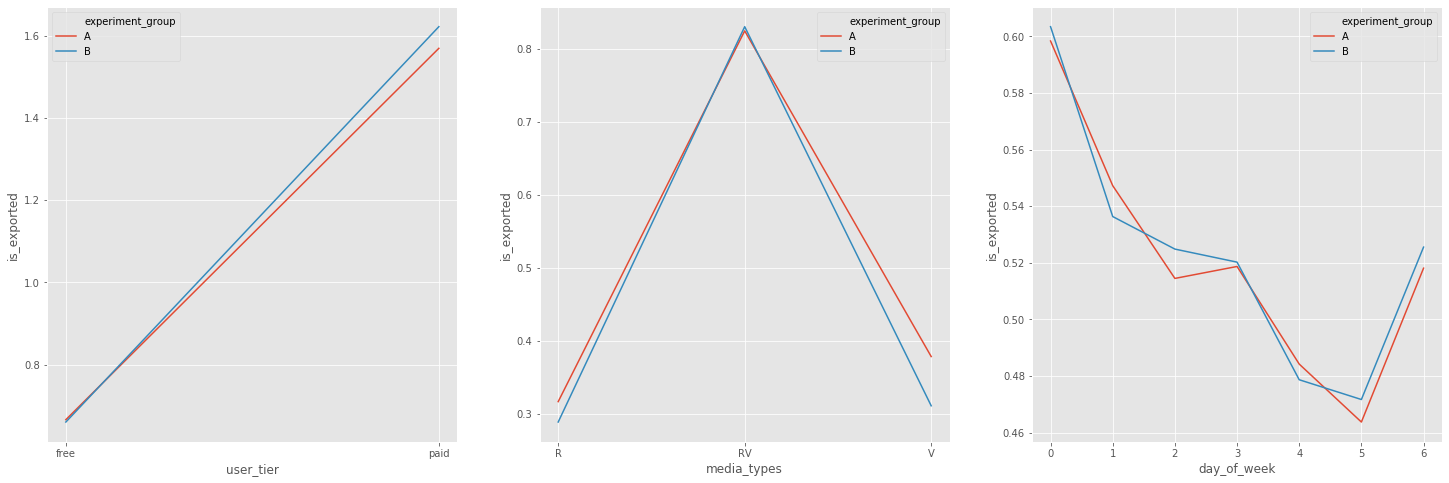

In [20]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(25,8))
temp=df_new.groupby(['user_tier','experiment_group','user_id'])['is_exported'].sum().reset_index()
temp=temp.groupby(['user_tier','experiment_group'])['is_exported'].mean().reset_index()
sns.lineplot(data=temp,x='user_tier',y='is_exported',hue='experiment_group',ax=ax.flatten()[0])

temp=df_new.groupby(['media_types','experiment_group','user_id'])['is_exported'].sum().reset_index()
temp=temp.groupby(['media_types','experiment_group'])['is_exported'].mean().reset_index()
sns.lineplot(data=temp,x='media_types',y='is_exported',hue='experiment_group',ax=ax.flatten()[1])


temp=df_new.groupby(['day_of_week','experiment_group','user_id'])['is_exported'].sum().reset_index()
temp=temp.groupby(['day_of_week','experiment_group'])['is_exported'].mean().reset_index()
sns.lineplot(data=temp,x='day_of_week',y='is_exported',hue='experiment_group',ax=ax.flatten()[2])

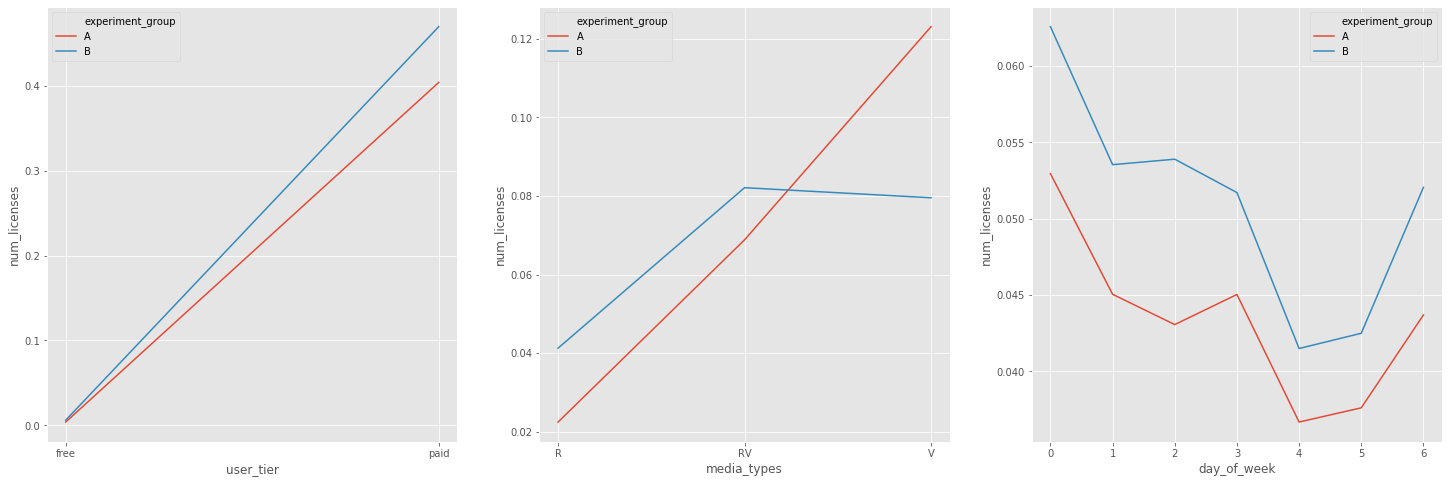

In [63]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(25,8))
temp=df_new.groupby(['user_tier','experiment_group','user_id'])['num_licenses'].sum().reset_index()
temp=temp.groupby(['user_tier','experiment_group'])['num_licenses'].mean().reset_index()
sns.lineplot(data=temp,x='user_tier',y='num_licenses',hue='experiment_group',ax=ax.flatten()[0])

temp=df_new.groupby(['media_types','experiment_group','user_id'])['num_licenses'].sum().reset_index()
temp=temp.groupby(['media_types','experiment_group'])['num_licenses'].mean().reset_index()
sns.lineplot(data=temp,x='media_types',y='num_licenses',hue='experiment_group',ax=ax.flatten()[1])


temp=df_new.groupby(['day_of_week','experiment_group','user_id'])['num_licenses'].sum().reset_index()
temp=temp.groupby(['day_of_week','experiment_group'])['num_licenses'].mean().reset_index()
sns.lineplot(data=temp,x='day_of_week',y='num_licenses',hue='experiment_group',ax=ax.flatten()[2])

## Experiment Analysis
**Unit of diversion**: user_id

**Method**: Difference of mean between average number of two groups can be detecetd using T-test

**Hypothesis:**     
Null hypothesis: there is no difference between mean of two groups    
Alternative hypothesis: there is difference between mean of two groups (larger or smaller) 

**Significance level**:Here I choose 95% 

In [14]:
from statistics import stdev
from scipy.stats import t

def ab_test_mean(df,variable,f): 
    data=df
    a=data[data.experiment_group=='A'].groupby('user_id')[variable].agg(f)
    b=data[data.experiment_group=='B'].groupby('user_id')[variable].agg(f)
    
    mean_a=a.mean()
    mean_b=b.mean()
    std_a=stdev(a)
    std_b=stdev(b)
    na=a.shape[0]
    nb=b.shape[0]
    
    se=math.sqrt(pow(std_a,2)/na+pow(std_b,2)/nb)
    z_score=(mean_a-mean_b)/se
    
    print(variable)
    print('mean_a: {:.3f}'.format(mean_a))
    print('mean_b: {:.3f}'.format(mean_b))
    print('absolute diff is: {:.3f}'.format(mean_a-mean_b))
    
    #print('p_val={:.3f}'.format(2*norm.cdf(-abs(z_score))))
    print('p_val={:.3f}'.format(2*t.cdf(-abs((mean_a-mean_b)/se), na+nb-2)))
    
    
    print('CI:[{:.3f},{:.3f}]'.format((mean_a-mean_b)-norm.ppf(0.975)*se,
                       (mean_a-mean_b)+norm.ppf(0.975)*se))
    
    if 2*norm.cdf(-abs(z_score))<0.05:
                  print('Significant difference, reject null hypothesis')
    else:
                  print('No significant difference, cannot reject null hypothesis')
            

In [15]:
def ab_test_proportion(df,variable):
    data=df
    a=data[data.experiment_group=='A'][variable]
    b=data[data.experiment_group=='B'][variable] 
    
    rate_a=a.mean()
    rate_b=b.mean()
    na=a.shape[0]
    nb=b.shape[0]
    
    rate_pool=(a.sum()+b.sum())/(na+nb)
    se=math.sqrt(rate_pool*(1-rate_pool)*(1/na+1/nb))
    z_score=(rate_a-rate_b)/se
    
    print(variable)
    print('rate_a: {:.2%}'.format(rate_a))
    print('rate_b: {:.2%}'.format(rate_b))
    print('absolute diff is: {:.2%}'.format(rate_a-rate_b))
    print('p_val={:.3f}'.format(2*norm.cdf(-abs(z_score))))
    print('CI:[{:.2%},{:.2%}]'.format((rate_a-rate_b)-norm.ppf(0.975)*se,
                       (rate_a-rate_b)+norm.ppf(0.975)*se))
    
    if 2*norm.cdf(-abs(z_score))<0.05:
                  print('Significant difference, reject null hypothesis')
    else:
                  print('No significant difference, cannot reject null hypothesis')

In [26]:
# Key metrics 1: average num of finished design per user 
ab_test_mean(df_new,'is_exported','sum')

is_exported
mean_a: 0.975
mean_b: 0.980
absolute diff is: -0.005
p_val=0.477
CI:[-0.018,0.009]
No significant difference, cannot reject null hypothesis


In [27]:
# Key metrics 2: average num of licensed picture paid per user 
ab_test_mean(df_new,'num_licenses','sum')

num_licenses
mean_a: 0.082
mean_b: 0.098
absolute diff is: -0.015
p_val=0.000
CI:[-0.018,-0.012]
Significant difference, reject null hypothesis


In [28]:
# Accessory metrics 1: converstion rate between search and export 
ab_test_proportion(df_new,'is_exported')

is_exported
rate_a: 34.59%
rate_b: 34.45%
absolute diff is: 0.14%
p_val=0.098
CI:[-0.03%,0.30%]
No significant difference, cannot reject null hypothesis


In [29]:
# Accessory metrics 2:average num of search per user 
ab_test_mean(df_new,'search_id','count')

search_id
mean_a: 2.820
mean_b: 2.846
absolute diff is: -0.025
p_val=0.065
CI:[-0.052,0.002]
No significant difference, cannot reject null hypothesis


In [30]:
# Accessory metrics 3: average number of exported pictures 
ab_test_mean(df_new,'num_exported_results','sum')

num_exported_results
mean_a: 1.172
mean_b: 1.152
absolute diff is: 0.019
p_val=0.018
CI:[0.003,0.036]
Significant difference, reject null hypothesis


In [29]:
(0.083-0.070)*len(df_new.user_id.unique())

7277.2959999999985

# Question 1: overall impact of manual elevation

According to the experiment data, the manual elevation (group A) leads to **same number of finished design and less number of licensed pictures per user.**

Number of finished design per user in Manual Evelation/group A=0.827 = 2.993 times of search * 27.64% conversiton rate    
Number of finished design per user in Automated Evelation/group B=0.832 = 3.022 times of search * 27.53% conversiton rate 

Number of licensed pictures per user in Manual Evelation/group A=0.070   
Number of licensed pictures per user in Automated Evelation/group B=0.083

**Two groups have same number of finish design, but manual evelation has fewer licensed pictures, which is negative impact on company revenue**.
Based on experiment data, assume the price of licensed picture is 1 dollar (showed on the demo picture in description), the automated elevation can generate around $7k more revenue than manual elevation. 

**But manual evelation has positive impact on customer experience**.    
Conversion rate between search and downloading is not signficantly different, but average search times in manual group is significantly smaller than automated group. User in manual group can take fewer times of search to find right pictures. It also shows that manual group has more pictures exported, meaning user use more canva pictures in their designs.



# Question 2: list of suggestions

## I. continue study on segments 
Besides the overall result, it is necessary to look deeper into sub groups/ segments. Segments may have very opposite results. In that case, the company may use different search mechanism for different segments to achieve better outcome.

These segments could be:
* certain type of user   
* certain type of media request   
* certain type of query
* certain time period
* combination of above

## II. study on long-term value 
Besides the difference between user usage and related revenue from above analysi, different mechanism may have long-term impact on customer experience and the whole business, including:
* user retention rate
* recurring rate for paid user 
* user LTV 

Long-term value has huge impact on business, but it may require more data, like user payment duetime, user login info etc. Only based on provided experiment data, I don't think I could get solid conclusion of this topic. **So I will go for the segments in Question 3.**


# Question 3: analysis on segments
These segments could be:
* certain type of user
* certain type of media type
* certain type of query
* certain time period
* combination of above

From above EDA analysis, 99.3% data is from RV media type, so there is no need to analyze this variable.  
The most obvious segment is user type, I will go with it first.


In [33]:
def cat_plot_mean(df,variable1, variable2,f,ax):
    data=df
    temp=data.groupby(['experiment_group','user_id']+[variable1])[variable2].agg(f)
    temp=pd.DataFrame(temp).dropna().groupby(['experiment_group']+[variable1])[variable2].mean()
    temp=temp.reset_index()
    sns.catplot(data=temp,x=variable1,y=variable2,hue='experiment_group',kind='point',ax=ax)
    plt.close()

In [34]:
def cat_plot_rate(df,variable1,variable2,ax):
    data=df
    temp=data.groupby(['experiment_group']+[variable1])[variable2].mean()
    temp=temp.reset_index()
    sns.catplot(data=temp,x=variable1,y=variable2,hue='experiment_group',kind='point',ax=ax)
    plt.close()

Some user changed user_tier value during the experiment period, but only small proportion, here I ignore this small issue.

16% paid users accounts for 30% of finished design and 94% of licensed picture downloading. 

In [35]:
df_new.groupby(['user_tier']).user_id.nunique()/df_new.user_id.nunique()

user_tier
free    0.854660
paid    0.164622
Name: user_id, dtype: float64

In [36]:
df_new.groupby(['user_tier']).is_exported.sum()/df_new.is_exported.sum()

user_tier
free    0.683435
paid    0.316565
Name: is_exported, dtype: float64

In [37]:
df_new.groupby(['user_tier']).num_licenses.sum()/df_new.num_licenses.sum()

user_tier
free    0.056726
paid    0.943274
Name: num_licenses, dtype: float64

Text(0, 0.5, 'conversion_rate')

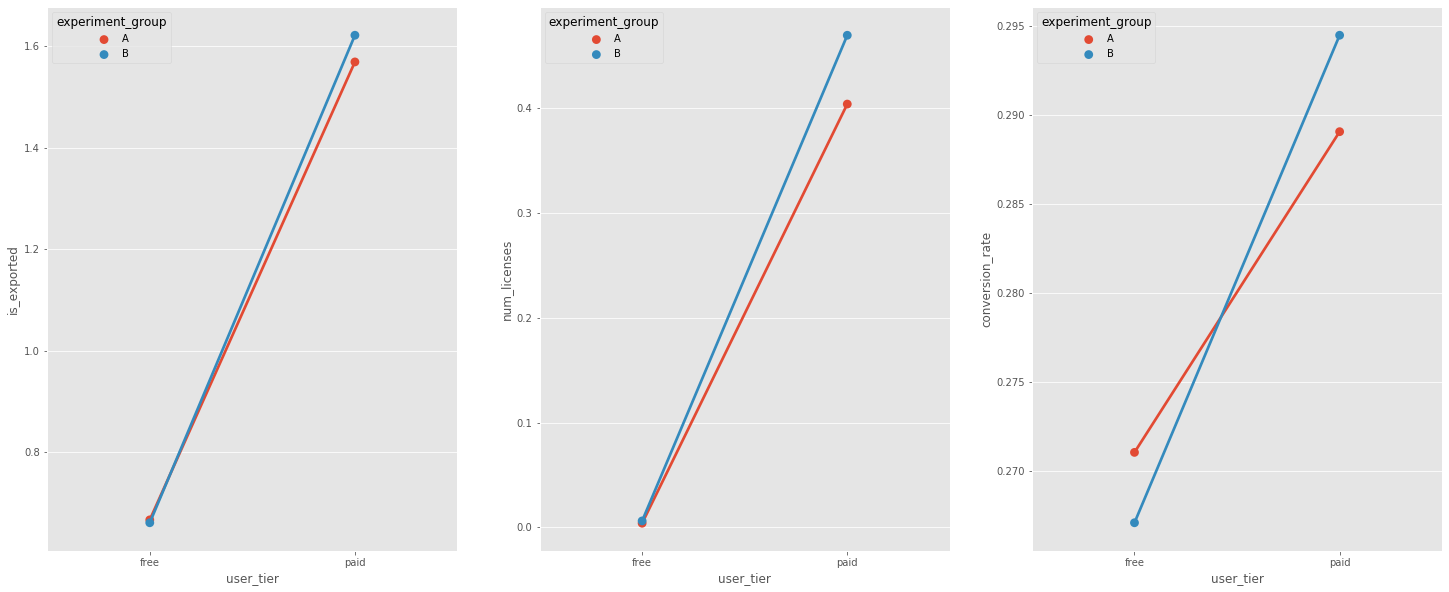

In [38]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(25,10))

cat_plot_mean(df_new,'user_tier','is_exported','sum',ax.flatten()[0])
cat_plot_mean(df_new,'user_tier','num_licenses','sum',ax.flatten()[1])
cat_plot_rate(df_new,'user_tier','is_exported',ax.flatten()[2])
plt.ylabel('conversion_rate')

In [39]:
# Key metrics 1: average num of finished design per user 
ab_test_mean(df_new[df_new.user_tier=='paid'],'is_exported','sum')

is_exported
mean_a: 1.569
mean_b: 1.622
absolute diff is: -0.053
p_val=0.021
CI:[-0.097,-0.008]
Significant difference, reject null hypothesis


In [40]:
# Key metrics 2: average num of licensed picture paid per user 
ab_test_mean(df_new[df_new.user_tier=='paid'],'num_licenses','sum')

num_licenses
mean_a: 0.404
mean_b: 0.469
absolute diff is: -0.066
p_val=0.000
CI:[-0.081,-0.051]
Significant difference, reject null hypothesis


In [41]:
# Accessory metrics 1: converstion rate between search and export 
ab_test_proportion(df_new[df_new.user_tier=='paid'],'is_exported')

is_exported
rate_a: 28.90%
rate_b: 29.45%
absolute diff is: -0.54%
p_val=0.000
CI:[-0.79%,-0.29%]
Significant difference, reject null hypothesis


In [42]:
# Key metrics 1: average num of finished design per user 
ab_test_mean(df_new[df_new.user_tier=='free'],'is_exported','sum')

is_exported
mean_a: 0.666
mean_b: 0.661
absolute diff is: 0.006
p_val=0.261
CI:[-0.004,0.016]
No significant difference, cannot reject null hypothesis


In [43]:
# Key metrics 2: average num of licensed picture paid per user 
ab_test_mean(df_new[df_new.user_tier=='free'],'num_licenses','sum')

num_licenses
mean_a: 0.004
mean_b: 0.006
absolute diff is: -0.002
p_val=0.000
CI:[-0.003,-0.002]
Significant difference, reject null hypothesis


In [44]:
# Accessory metrics 1: converstion rate between search and export 
ab_test_proportion(df_new[df_new.user_tier=='free'],'is_exported')

is_exported
rate_a: 27.10%
rate_b: 26.71%
absolute diff is: 0.40%
p_val=0.000
CI:[0.24%,0.56%]
Significant difference, reject null hypothesis


In [35]:
temp=df_new.sort_values(['user_id','experiment_day'],ascending=True)
f=pd.DataFrame(temp.groupby(['user_id','experiment_group']).user_tier.first()).reset_index()
l=pd.DataFrame(temp.groupby(['user_id','experiment_group']).user_tier.last()).reset_index()
tier_change=pd.merge(f,l,left_on='user_id',right_on='user_id')
tier_change.head()

,user_id,experiment_group_x,user_tier_x,experiment_group_y,user_tier_y
0,00000427,A,free,A,free
1,000006c2,B,free,B,free
2,000017f9,B,free,B,free
3,00002e66,A,free,A,free
4,00007269,A,free,A,free


In [37]:
tier_change[tier_change.user_tier_x=='free'].groupby('experiment_group_x').user_id.count()

experiment_group_x
A    197907
B    197555
Name: user_id, dtype: int64

In [39]:
tier_change[(tier_change.user_tier_x=='free')&(tier_change.user_tier_y=='paid')].groupby(
    'experiment_group_x').user_id.count()

experiment_group_x
A    2824
B    2851
Name: user_id, dtype: int64

In [42]:
rate_a=2824/197907
rate_b=2851/197555
na=197907
nb=197555
    
rate_pool=(2824+2851)/(197907+197555)
se=math.sqrt(rate_pool*(1-rate_pool)*(1/na+1/nb))
z_score=(rate_a-rate_b)/se
    

print('rate_a: {:.2%}'.format(rate_a))
print('rate_b: {:.2%}'.format(rate_b))
print('absolute diff is: {:.2%}'.format(rate_a-rate_b))
print('p_val={:.3f}'.format(2*norm.cdf(-abs(z_score))))
print('CI:[{:.2%},{:.2%}]'.format((rate_a-rate_b)-norm.ppf(0.975)*se,
                       (rate_a-rate_b)+norm.ppf(0.975)*se))
if 2*norm.cdf(-abs(z_score))<0.05:
    print('Significant difference, reject null hypothesis')
else:
    print('No significant difference, cannot reject null hypothesis')

rate_a: 1.43%
rate_b: 1.44%
absolute diff is: -0.02%
p_val=0.668
CI:[-0.09%,0.06%]
No significant difference, cannot reject null hypothesis


## Finding & Suggestion 1

For paid user, automated/ group b shows significantly better performance in both number of finished design and licensed pictures, even conversion rate.    
**I suggest to use automated elevation for paid users.**

For free user, manual/group a has same quantity of finished designs, significantly fewer licensed pictures but higher conversion rate. There is still tradeoff between user experience and company revenue. 

Because all these segments are related to each other, to remove the confounding factors, next step I will stick to free users,and find certain circumstances where free users show strong preference.  
I will start with day of week.

In [45]:
df_new['is_weekend']=np.where(df_new.day_of_week.isin([4,5]),1,0)

Text(0, 0.5, 'conversion_rate')

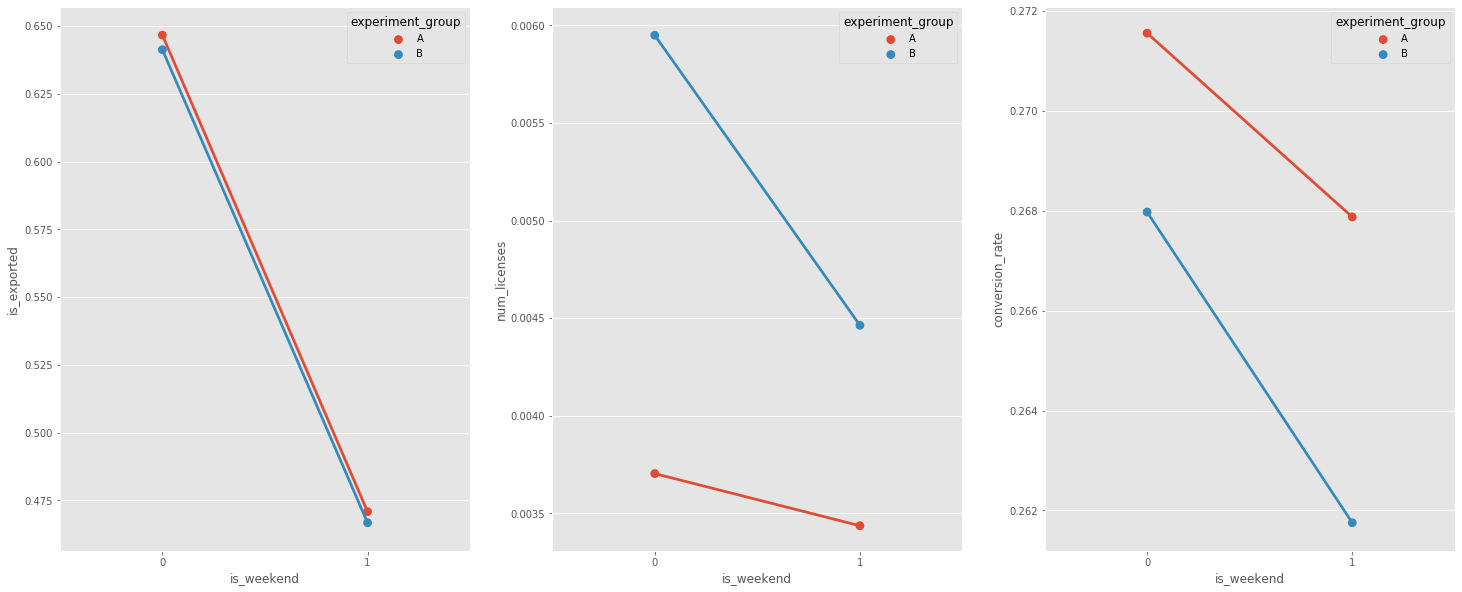

In [46]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(25,10))
h=df_new[df_new.user_tier=='free']

cat_plot_mean(h,'is_weekend','is_exported','sum',ax.flatten()[0])
cat_plot_mean(h,'is_weekend','num_licenses','sum',ax.flatten()[1])
cat_plot_rate(h,'is_weekend','is_exported',ax.flatten()[2])
plt.ylabel('conversion_rate')

Workday or weekend is not a good segment for free users.   

I will check query next, query is difficult and related to NLP. To simplify, I only study popularity of query and evelation number of query.

Text(0, 0.5, 'percentage of total')

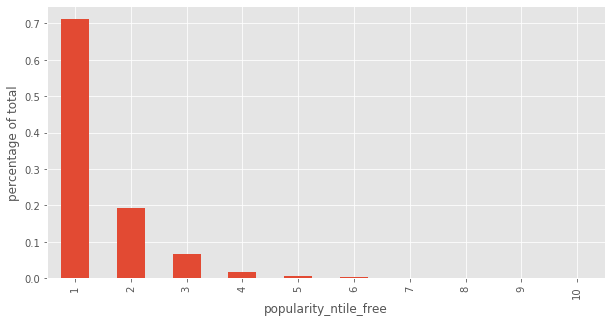

In [47]:
# query popularity 
x=df_new[df_new.user_tier=='free']['query'].value_counts().sort_values(ascending=False)
x=pd.DataFrame(x).reset_index()
x.columns=['query','cnt']

x['popularity_ntile_free']=pd.qcut(x.cnt,q=10,labels=list(10-x for x in range(10)))
(x.groupby('popularity_ntile_free').cnt.sum().sort_values(ascending=False)/x.cnt.sum()).plot(kind='bar',figsize=(10,5))
plt.ylabel('percentage of total')

distribution of query is long tail, top 10 percent of queries accounts for  70% of all searches, last 60% percent only accounts for 2%. 

In [48]:
x[x.popularity_ntile_free==1]['query'].unique() 

array(['arrow', 'heart', 'instagram', 'line', 'flowers', 'circle',
       'rectangle', 'birthday', 'money', 'square', 'banner', 'star',
       'border', 'water', 'computer', 'house', 'stars', 'coffee', 'love',
       'fruit', 'lines', 'tree', 'frame', 'free', 'box', 'mothers day',
       'arrows'], dtype=object)

In [49]:
df_new=pd.merge(df_new, x[['query','popularity_ntile_free']], left_on='query',right_on='query',how='left')

In [50]:
df_new['popularity_class_free']=df_new['popularity_ntile_free'].apply(lambda x:'high' if x==1 else
                                                            ('medium' if x==2 else 'low'))

Text(0, 0.5, 'conversion_rate')

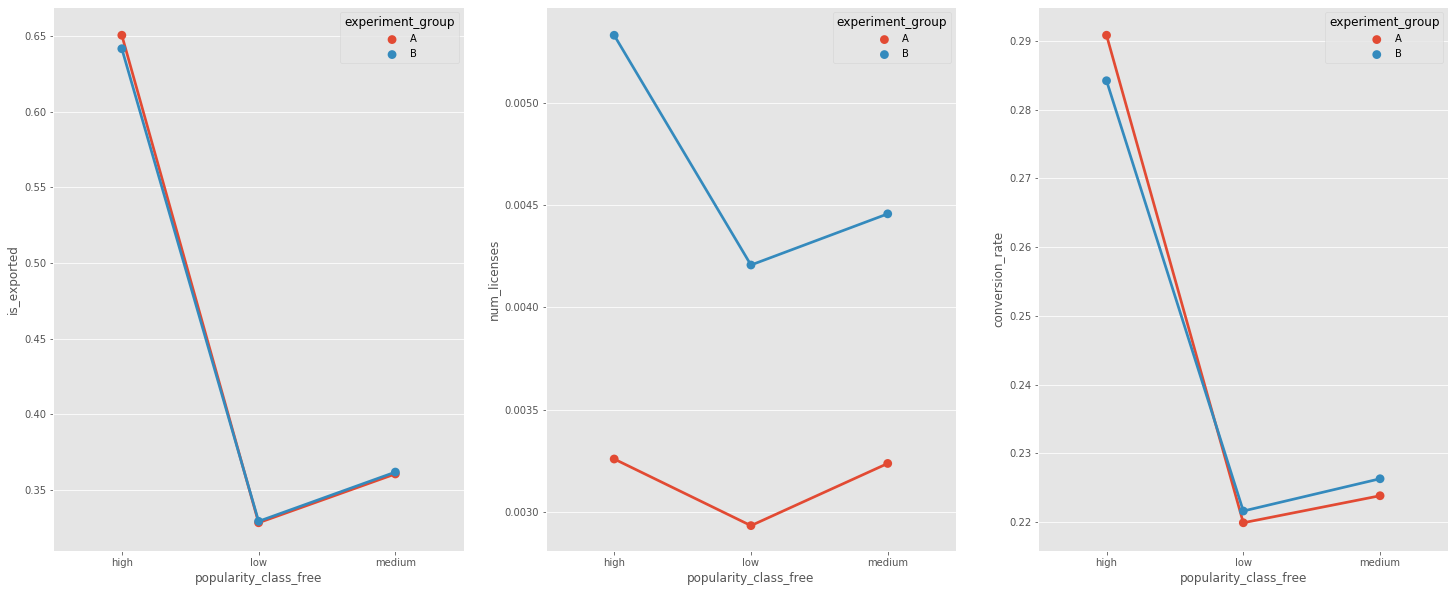

In [51]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(25,10))
h=df_new[(df_new.user_tier=='free')]

cat_plot_mean(h,'popularity_class_free','is_exported','sum',ax.flatten()[0])
cat_plot_mean(h,'popularity_class_free','num_licenses','sum',ax.flatten()[1])
cat_plot_rate(h,'popularity_class_free','is_exported',ax.flatten()[2])
plt.ylabel('conversion_rate')

In [52]:
# Key metrics 1: average num of finished design per user 
ab_test_mean(df_new[(df_new.popularity_class_free.isin(['medium','low']))&(df_new.user_tier=='free')],
             'is_exported','sum')

print(' ')
# Key metrics 2: average num of licensed picture paid per user 
ab_test_mean(df_new[(df_new.popularity_class_free.isin(['medium','low']))&(df_new.user_tier=='free')],
             'num_licenses','sum')
print(' ')

# Accessory metrics 1: converstion rate between search and export 
ab_test_proportion(df_new[(df_new.popularity_class_free.isin(['medium','low']))&(df_new.user_tier=='free')],
                   'is_exported')

is_exported
mean_a: 0.385
mean_b: 0.386
absolute diff is: -0.001
p_val=0.763
CI:[-0.009,0.007]
No significant difference, cannot reject null hypothesis
 
num_licenses
mean_a: 0.003
mean_b: 0.005
absolute diff is: -0.001
p_val=0.000
CI:[-0.002,-0.001]
Significant difference, reject null hypothesis
 
is_exported
rate_a: 22.25%
rate_b: 22.48%
absolute diff is: -0.22%
p_val=0.119
CI:[-0.50%,0.06%]
No significant difference, cannot reject null hypothesis


## Finding & Suggestion 2

When free users search for medium and low popular queries, automated evelation/group b has better outcome on number of licenses pictures, also no worse outcome on number of finished design and conversion rate.

**I suggest to use automated elevation for free users when they search for medium/low popular querues.**

In [53]:
# query evelation numbers 
y=df_new[df_new.experiment_group=='A'].groupby('query').num_elevations.agg([np.mean])
y['evelation_ntile']=pd.qcut(y['mean'],q=10,labels=list(10-x for x in range(10)))
y=y.rename(columns={'mean':'num_evelation_manual'})
y.groupby('evelation_ntile')['num_evelation_manual'].agg(['min','max'])

,min,max
evelation_ntile,,
10,0.000000,8.000000
9,8.818792,18.000000
8,18.998651,26.000000
7,28.000000,36.000000
6,37.000000,43.000000
5,44.000000,59.000000
4,60.000000,77.000000
3,77.578708,80.000000
2,81.000000,124.000000


In [54]:
df_new=pd.merge(df_new, y, left_on='query',right_on='query',how='left')

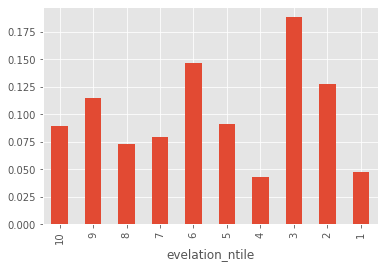

In [55]:
(df_new.groupby('evelation_ntile').search_id.count()/df_new.search_id.count()).plot(kind='bar')

Text(0, 0.5, 'conversion_rate')

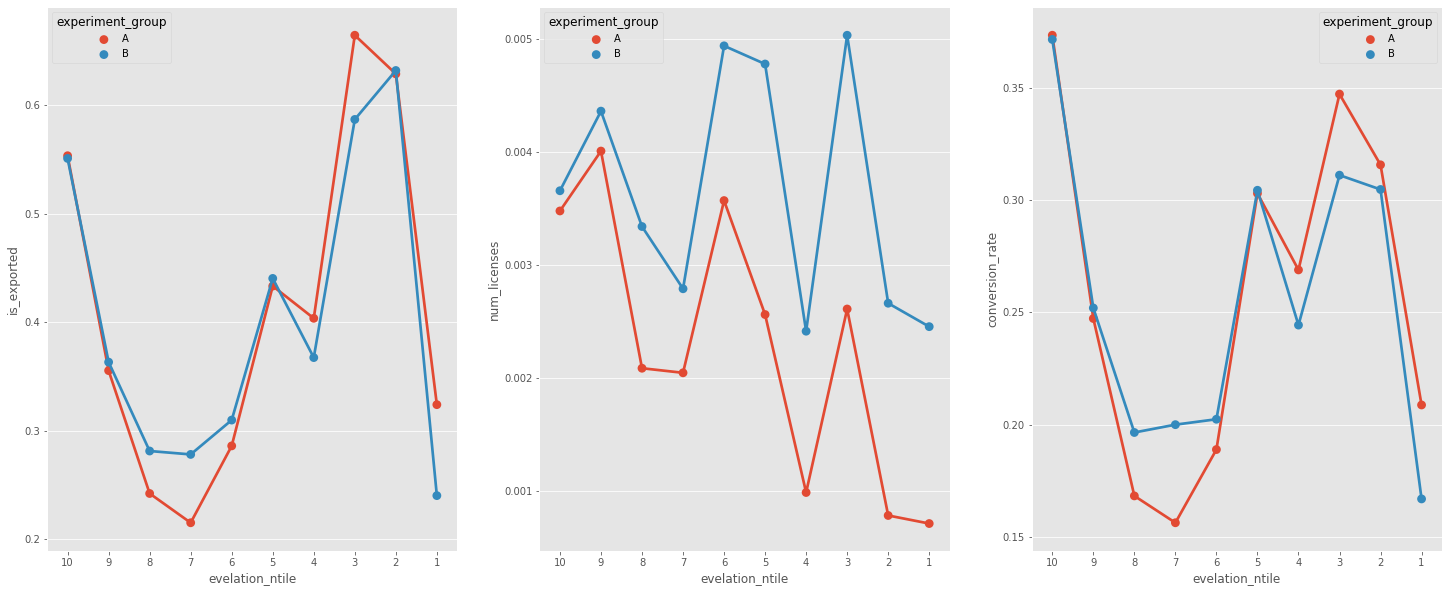

In [56]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(25,10))
h=df_new[(df_new.user_tier=='free')]

cat_plot_mean(h,'evelation_ntile','is_exported','sum',ax.flatten()[0])
cat_plot_mean(h,'evelation_ntile','num_licenses','sum',ax.flatten()[1])
cat_plot_rate(h,'evelation_ntile','is_exported',ax.flatten()[2])
plt.ylabel('conversion_rate')

It is showed above, after 6th evelation ntile, gorup b performs better. Queries in 6th evelation ntile has around 40 evelations. And the description mentioned automated can have 50 evelations most. So I use 50 evelations as cut point.

In [57]:
df_new['is_over_50_evelation']=np.where(df_new.num_evelation_manual>50,1,0)
df_new[df_new.user_tier=='free'].groupby('is_over_50_evelation').search_id.count()/df_new[df_new.user_tier=='free'].search_id.count()


is_over_50_evelation
0    0.518729
1    0.481271
Name: search_id, dtype: float64

In [58]:
# Key metrics 1: average num of finished design per user 
ab_test_mean(df_new[(df_new.is_over_50_evelation==0)&(df_new.user_tier=='free')],
             'is_exported','sum')

print(' ')
# Key metrics 2: average num of licensed picture paid per user 
ab_test_mean(df_new[(df_new.is_over_50_evelation==0)&(df_new.user_tier=='free')],
             'num_licenses','sum')
print(' ')

# Accessory metrics 1: converstion rate between search and export 
ab_test_proportion(df_new[(df_new.is_over_50_evelation==0)&(df_new.user_tier=='free')],
                   'is_exported')

is_exported
mean_a: 0.420
mean_b: 0.445
absolute diff is: -0.025
p_val=0.000
CI:[-0.031,-0.019]
Significant difference, reject null hypothesis
 
num_licenses
mean_a: 0.004
mean_b: 0.005
absolute diff is: -0.001
p_val=0.000
CI:[-0.002,-0.001]
Significant difference, reject null hypothesis
 
is_exported
rate_a: 22.94%
rate_b: 24.19%
absolute diff is: -1.26%
p_val=0.000
CI:[-1.47%,-1.05%]
Significant difference, reject null hypothesis


## Finding & Suggestion 3

When free user search for queries with few evelations, automated evelation/group b has better outcome.

**I suggest to use automated elevation for free users when searching for queries with less than 50 manual evelations.**


## In colusion
paid user +free user search for unpopular/few manual evelation queries account for 74% of total data. Under these circumstances, automated elevation shows better performance than manual evelation.    
For the rest circumstances, manual evelation has higher number of finished designs and better conversion rate. 

In [59]:
df_new['is_paid']=np.where(df_new.user_tier=='paid',1,0)
df_new['is_free_unpop']=np.where((df_new.user_tier=='free')&(df_new.popularity_class_free!='high'),1,0)
df_new['is_free_less50']=np.where((df_new.user_tier=='free')&(df_new.is_over_50_evelation==0),1,0)

rest=df_new[(df_new['is_paid']==0)&(df_new.is_free_unpop==0)&(df_new.is_free_less50==0)]

print('Paid user +free user search for unpopular/less than 50 manual evelation queries composes {:.2%} of total data'.format(
    1-rest.shape[0]/df_new.shape[0]))
print('The rest composes {:.2%} of total data'.format(rest.shape[0]/df_new.shape[0]))


Paid user +free user search for unpopular/less than 50 manual evelation queries composes 74.31% of total data
The rest composes 25.69% of total data


**Performance of paid user +free user search for unpopular/less than 50 manual evelation queries**

In [60]:
auto=df_new[(df_new['is_paid']==1)|(df_new.is_free_unpop==1)|(df_new.is_free_less50==1)]
# Key metrics 1: average num of finished design per user 
ab_test_mean(auto,'is_exported','sum')

print(' ')
# Key metrics 2: average num of licensed picture paid per user 
ab_test_mean(auto,'num_licenses','sum')
print(' ')

# Accessory metrics 1: converstion rate between search and export 
ab_test_proportion(auto,'is_exported')

is_exported
mean_a: 0.672
mean_b: 0.702
absolute diff is: -0.031
p_val=0.000
CI:[-0.041,-0.020]
Significant difference, reject null hypothesis
 
num_licenses
mean_a: 0.083
mean_b: 0.097
absolute diff is: -0.014
p_val=0.000
CI:[-0.018,-0.011]
Significant difference, reject null hypothesis
 
is_exported
rate_a: 25.17%
rate_b: 26.05%
absolute diff is: -0.88%
p_val=0.000
CI:[-1.03%,-0.72%]
Significant difference, reject null hypothesis


**Performance of rest**

In [61]:
# Key metrics 1: average num of finished design per user 
ab_test_mean(rest,'is_exported','sum')

print(' ')
# Key metrics 2: average num of licensed picture paid per user 
ab_test_mean(rest,'num_licenses','sum')
print(' ')

# Accessory metrics 1: converstion rate between search and export 
ab_test_proportion(rest,'is_exported')

is_exported
mean_a: 0.803
mean_b: 0.740
absolute diff is: 0.063
p_val=0.000
CI:[0.045,0.081]
Significant difference, reject null hypothesis
 
num_licenses
mean_a: 0.002
mean_b: 0.005
absolute diff is: -0.003
p_val=0.000
CI:[-0.004,-0.002]
Significant difference, reject null hypothesis
 
is_exported
rate_a: 34.77%
rate_b: 31.83%
absolute diff is: 2.94%
p_val=0.000
CI:[2.66%,3.22%]
Significant difference, reject null hypothesis


# Question 4: final recommendation
Overall manual evelation has positive impact on customer experience, fewer search times. But negative impact on business revenue because of fewer number of licensed pictures.
After analysis on segments, it is found under some circumstances, automated evelation has better outcome than manual evelation. Under the rest of circumstances, manual elevation has higher number of finished design and conversion rate.
The circumstances I suggest to use automated evelation are:   
- paid user   
- free user searching for unpopular query   
- free user searching for query with less than 50 manual evelations


My final suggesition is **using aotumated evelation under above circumstances , and keeping manual elevation under the rest of situations** (number of finished design and customer experience have higher priority than making revenue, especially for free users.) 

This is just very rough suggestion, a better way maybe using algorithm (like uplift model) to find out the better mechanism for each user. 